# Basic Learning About YOLO Dataset

### What does YOLO dataset format look like?
```
 data_directory/
    ├── images/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   ├── ...
    │   └── imageN.jpg
    └── labels/
        ├── image1.txt
        ├── image2.txt
        ├── ...
        └── imageN.txt 


```


### What does label data look like?
```
2 0.561805 0.503788 0.865275 0.983333
0 0.569729 0.083333 0.310611 0.139394
3 0.477813 0.838636 0.329628 0.089394
```

- a row --> an object detecting in this image
- the meaning of each element within each row:
    - label 
    - the bounding box middle point x 
    - the bounding box middle point y
    - the bounding box width
    - the bounding box heigth




# Check GPU Setting
Remember to click Accelerator to activate GPU for the model training, and the you may use `nvydia-smi` to check current status of GPU

In [ ]:
! nvidia-smi

# Install Needed Packages

In [ ]:
# install packages used in YOLO model
! pip install ultralytics

In [1]:
# check model
import ultralytics
ultralytics.checks() 

Ultralytics 8.3.241  Python-3.12.4 torch-2.9.1+cpu CPU (13th Gen Intel Core i7-13700H)
Setup complete  (20 CPUs, 31.7 GB RAM, 538.7/679.8 GB disk)


# Data Analytics - EDA
Let's take a look at the overall data pattern for further model training

### Get Data Size, Class Count

In [10]:
from pathlib import Path
from glob import glob
from itertools import chain
from collections import Counter
from pprint import pprint

id2class_map = {
    '0': 'with helmet', 
    '1': 'without helmet', 
    '2': 'rider', 
    '3': 'number_plate'
}
main_path = Path("data") 

def print_data_size(folder_type):
    data_size = len(list((main_path / folder_type / "labels").glob("*.txt")))
    print(f'{folder_type} data count: {data_size}')

def print_class_count(folder_type):
    class_list = []
    for file in (main_path / folder_type / "labels").glob("*.txt"):
        class_list.append([row.split()[0] for row in file.read_text().splitlines()])
    counter = Counter(chain(*class_list))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}': v for k, v in counter.items()})
    print()

print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')  

train data count: 104
-- data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 20
-- data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 23,
 '3. number_plate': 22}



### Plot Training Images

In [11]:
# plot training images
import os
import cv2
from matplotlib import pyplot as plt

main_path = Path("data")

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    ''' get bbox and label information from label txt files '''
    
    # read file from path
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()
    
    # extract bboxes and labels from the label file
    bboxes = [
        [float(n) for n in line.split()[1:]]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]
    
    return bboxes, labels
    
def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924
    
    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox
    
    # calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2
    
    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)
    
    return x_min, y_min, x_max, y_max

class2color_map = {
    'with helmet': (0,255,128),
    'without helmet': (255,51,51),
    'rider': (51,255,255),
    'number_plate': (224,102,255)
}

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):
        
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)
        
        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)
        
        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

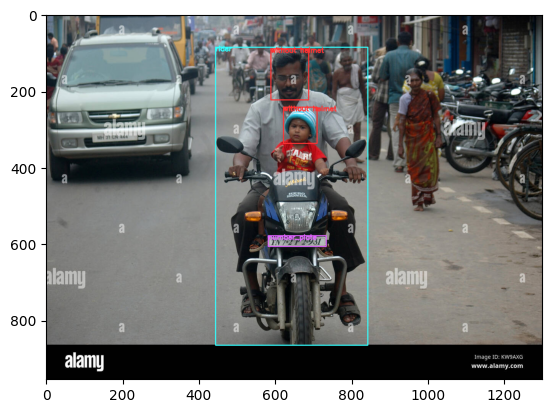

In [12]:
plot_image(image_name='new100')

# Load YOLO8 Model

In [13]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Display model information (optional)
model.info()

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(129, 3157200, 0, 8.8575488)

# Set yaml & Model Training

In [14]:
import yaml

# read the content of coco128.yaml
with open(os.path.join(main_path, 'coco128.yaml'), 'r') as file:
    print(file.read())

train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]


In [16]:
# creata the yaml based on coco128 for model training
data = {
    'train': 'train',
    'val': 'val',
    'nc': 4,
    'names': [
        'with helmet',
        'without helmet',
        'rider',
        'number plate'
    ]
}

with open('data/coco128.yaml', 'w') as file:
    yaml.dump(data, file)

# check the content of data.yaml
with open('data/coco128.yaml', 'r') as file:
    print(file.read())

names:
- with helmet
- without helmet
- rider
- number plate
nc: 4
train: train
val: val



In [ ]:
# disable wandb
os.environ['WANDB_MODE'] = "disabled"


# command to train the YOLOv8 model
model.train(
    data='data/coco128.yaml',
    epochs=50,
    workers=1,
    batch=8,
)

Ultralytics 8.3.241  Python-3.12.4 torch-2.9.1+cpu CPU (13th Gen Intel Core i7-13700H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/coco128.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

# Check Val Detecting Image
We may check the detection result of our validation images.

In [ ]:
# select the best model for checking prediction plot
# the model is saved in best.pt directly after training
model = YOLO('runs/detect/train/weights/best.pt')

In [ ]:
# use results from `model.predict()` for plotting 
def plot_pred_image(image_name, id2class_map=id2class_map, class2color_map=class2color_map):
    image_path = os.path.join(main_path, 'val', 'images', f'{image_name}.jpg')
    
    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]
    for bbox, label in zip(bboxes, labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]
        
        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)
        
        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

In [ ]:
image_name = 'new94'
print('prediction ↓')
plot_pred_image(image_name=image_name)
print('actual image ↓')
plot_image(image_name=image_name, data_type='val')